In [12]:
import torch
from torch.utils.data import DataLoader
from train import Trainer
from generator import *
from discriminator import GAN
from dataset import CocoStuffDataSet
import os, argparse, datetime, json

from utils import *
NUM_CLASSES = 81
SAVE_DIR = "../checkpoints" # Assuming this is launched from code/ subfolder.
experiment_name = 'weighted_full_data_higherlr'
experiment_dir = os.path.join(SAVE_DIR, experiment_name)
batch_size = 64

In [13]:
HEIGHT, WIDTH = 128, 128
val_loader = DataLoader(CocoStuffDataSet(mode='val', height=HEIGHT, width=WIDTH),
                            batch_size, shuffle=True)
train_loader = DataLoader(CocoStuffDataSet(mode='train', height=HEIGHT, width=WIDTH),
                            batch_size, shuffle=True)

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
Loaded 5000 samples: 
tensor([ 0.0004,  0.0071,  0.0020,  0.0066,  0.0109,  0.0056,  0.0067,
         0.0042,  0.0087,  0.0055,  0.0123,  0.0153,  0.0285,  0.0045,
         0.0084,  0.0057,  0.0060,  0.0082,  0.0162,  0.0121,  0.0119,
         0.0215,  0.0124,  0.0105,  0.0046,  0.0061,  0.0036,  0.0073,
         0.0101,  0.0126,  0.0088,  0.0215,  0.0062,  0.0116,  0.0109,
         0.0106,  0.0083,  0.0071,  0.0063,  0.0028,  0.0096,  0.0027,
         0.0068,  0.0058,  0.0069,  0.0034,  0.0103,  0.0139,  0.0108,
         0.0124,  0.0149,  0.0130,  0.0207,  0.0069,  0.0170,  0.0085,
         0.0018,  0.0054,  0.0061,  0.0071,  0.0021,  0.0071,  0.0051,
         0.0058,  0.0120,  0.0073,  0.0100,  0.0049,  0.0196,  0.0092,
         0.1320,  0.0056,  0.0105,  0.0046,  0.0052,  0.0077,  0.0377,
         0.0112,  0.1173,  0.0311,  0.0002])
loading annotations into memory...
Done (t=20.93s)
creating index...


In [14]:
generator = SegNet16(NUM_CLASSES)

image_shape = (3, HEIGHT, WIDTH)
segmentation_shape = (NUM_CLASSES, HEIGHT, WIDTH)
# discriminator = GAN(NUM_CLASSES, segmentation_shape, image_shape)
discriminator = None
trainer = Trainer(generator, discriminator, train_loader, val_loader, \
                experiment_dir=experiment_dir, resume=True)


44
Using device cuda:0
Runing network without GAN loss.
=> loading checkpoint '../checkpoints/weighted_full_data_higherlr/ckpt.pth.tar'
=> loaded checkpoint '../checkpoints/weighted_full_data_higherlr/ckpt.pth.tar' (iter 266)


In [15]:

# just do evaluation
# trainer.evaluate_meanIOU(train_loader, debug=True)

# print("Ignoring background")
# train_acc = trainer.evaluate_pixel_accuracy(train_loader, ignore_background=True)
# val_acc = trainer.evaluate_pixel_accuracy(val_loader, ignore_background=True)
# print("Train pixel accuracy: {}".format(train_acc))
# print("Val pixel accuracy: {}".format(val_acc))

def visualize_mask(loader, number):
    total = 0
    for data, mask_gt, gt_visual in loader:
        if total < number:      
            data = data.to(trainer.device)
            batch_size = data.size()[0]
            total += batch_size
            mask_pred = convert_to_mask(trainer._gen(data))
            for i in range(len(data)):
                img = data[i].detach().cpu().numpy()
                gt_mask = gt_visual[i].detach().cpu().numpy()
                pred_mask = np.argmax(mask_pred[i].detach().cpu().numpy(), axis=0)

                display_image = np.transpose(img, (1, 2, 0))
                plt.figure()

                plt.subplot(131)
                plt.imshow(display_image)
                plt.axis('off')
                plt.title('original image')

                cmap = discrete_cmap(NUM_CLASSES, 'Paired')
                norm = colors.NoNorm(vmin=0, vmax=NUM_CLASSES)

                plt.subplot(132)
                plt.imshow(display_image)
                plt.imshow(gt_mask, alpha=0.8, cmap=cmap, norm=norm)
                plt.axis('off')
                plt.title('real mask')

                plt.subplot(133)
                plt.imshow(display_image)
                plt.imshow(pred_mask, alpha=0.8, cmap=cmap, norm=norm)
                plt.axis('off')
                plt.title('predicted mask')
                plt.show()
        else:
            break



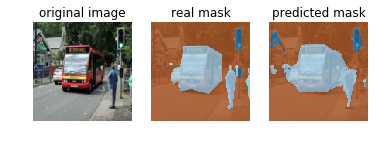

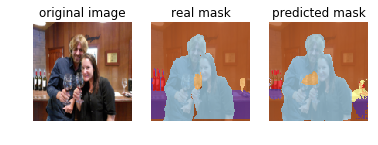

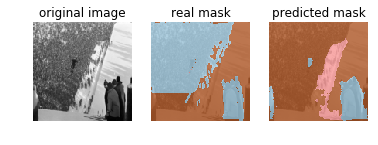

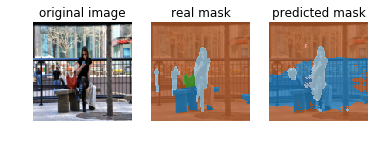

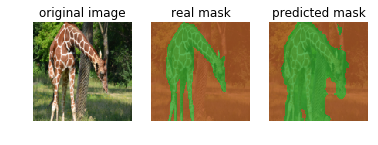

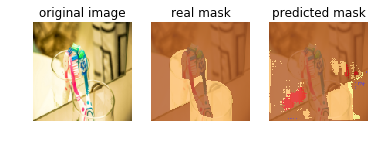

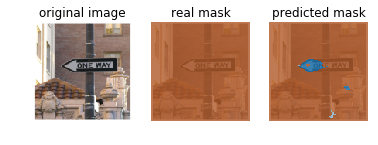

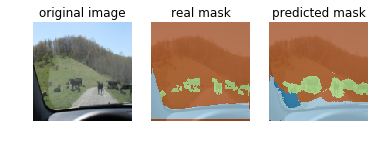

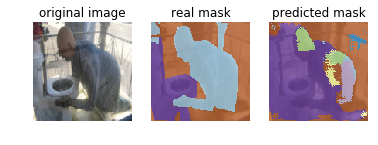

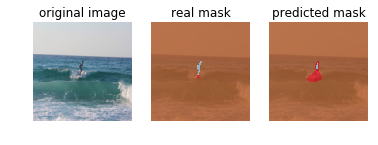

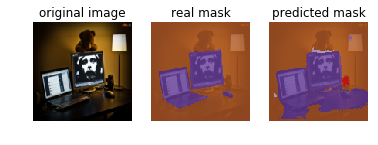

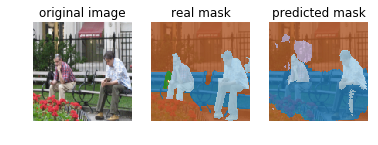

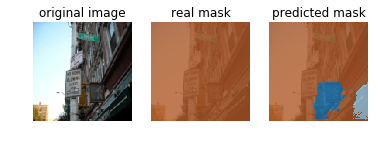

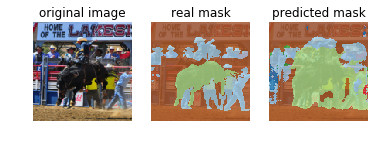

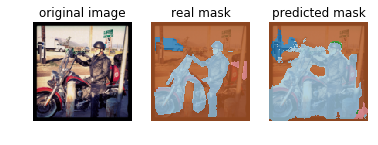

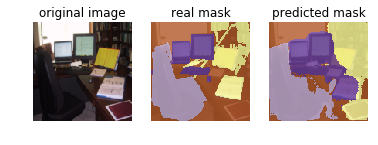

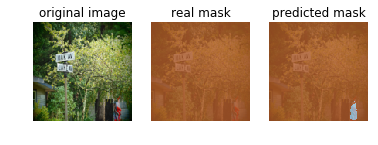

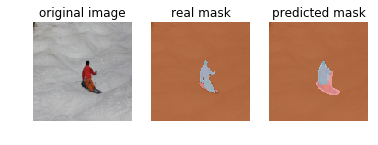

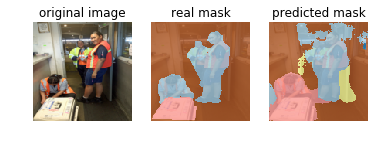

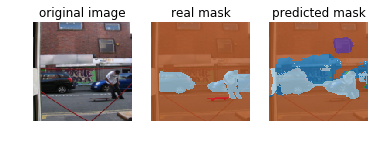

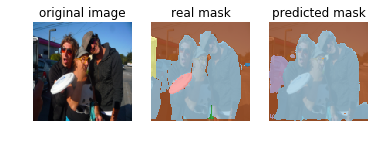

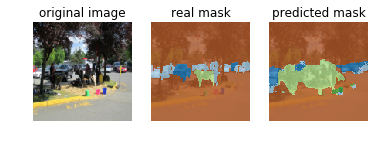

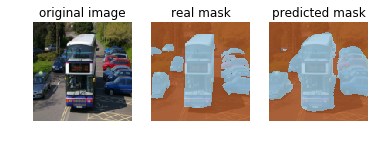

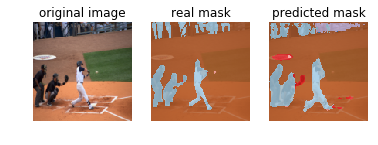

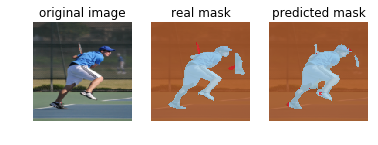

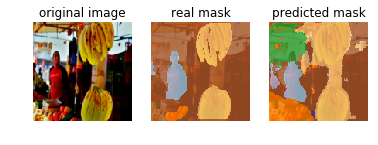

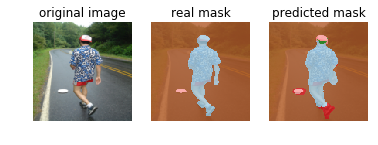

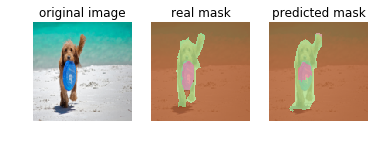

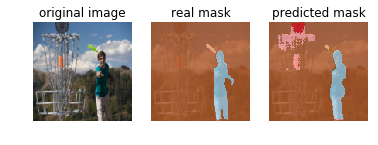

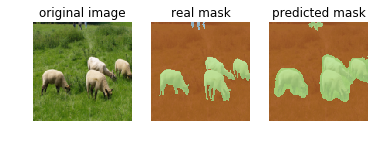

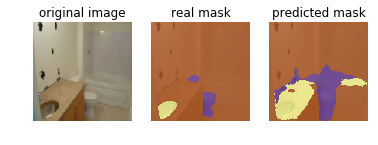

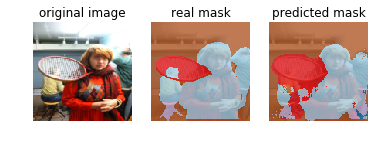

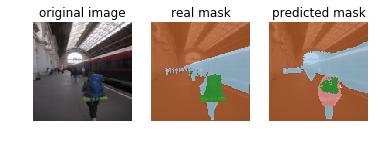

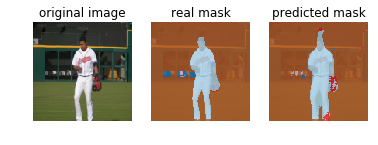

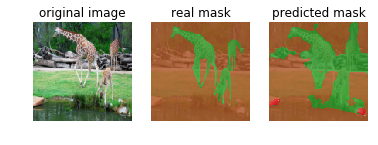

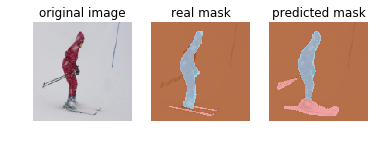

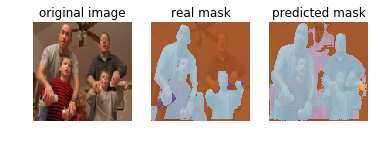

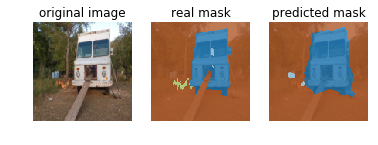

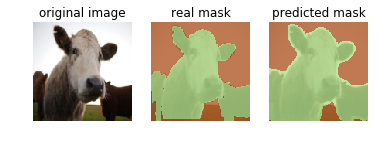

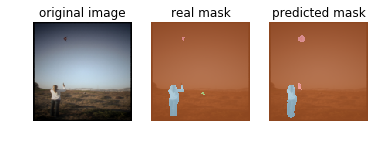

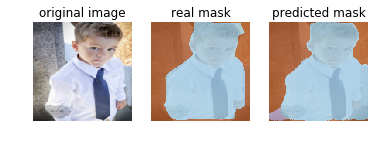

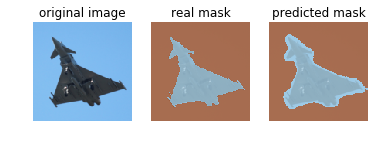

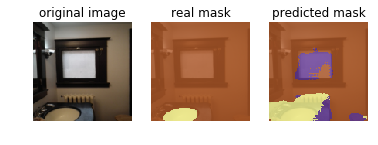

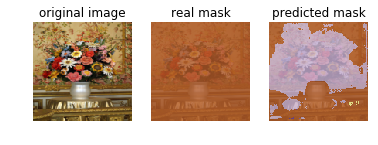

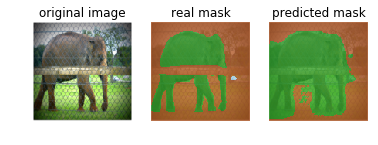

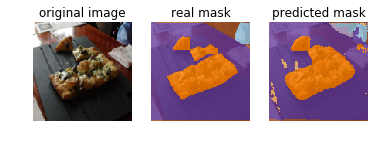

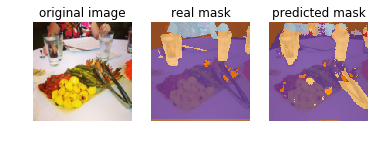

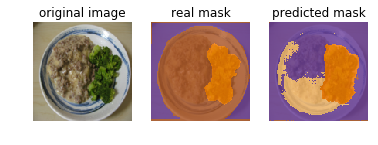

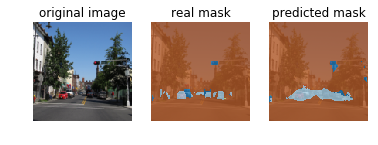

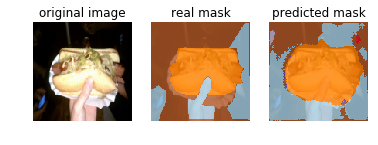

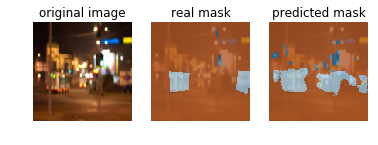

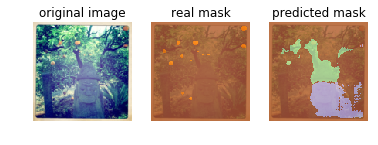

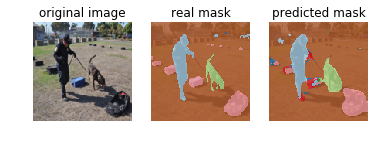

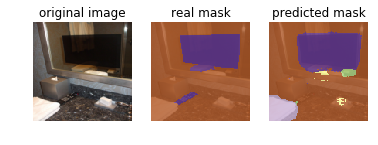

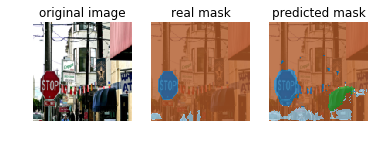

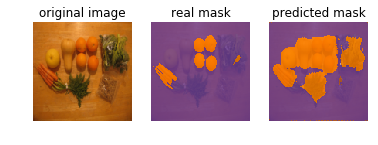

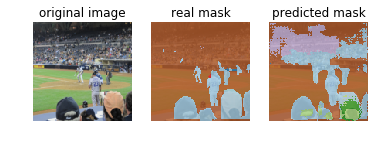

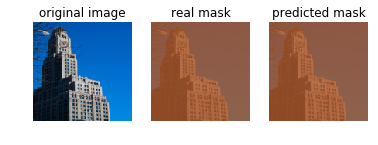

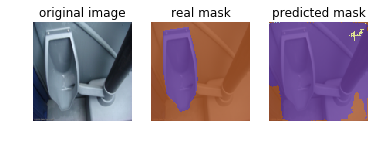

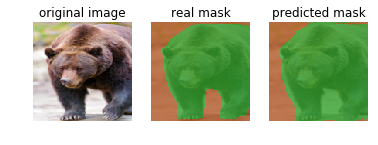

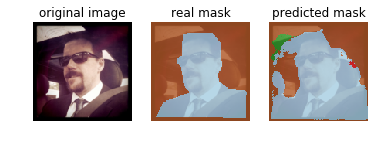

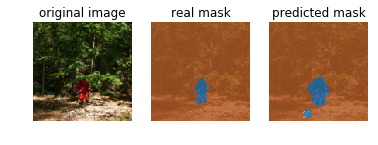

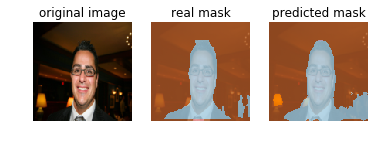

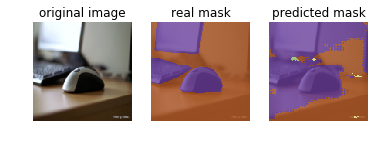

In [16]:
visualize_mask(train_loader, 30)

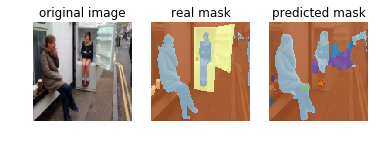

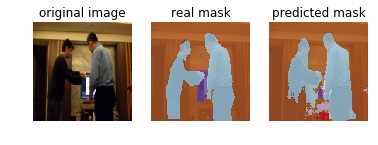

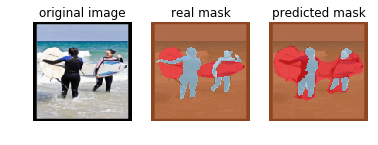

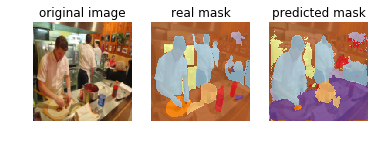

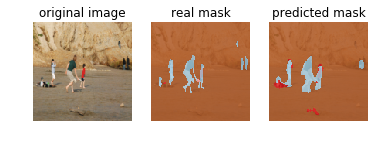

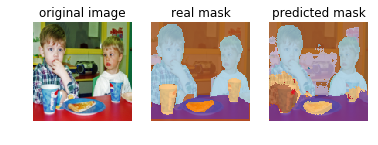

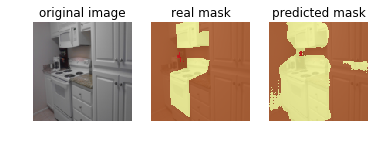

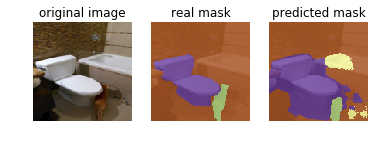

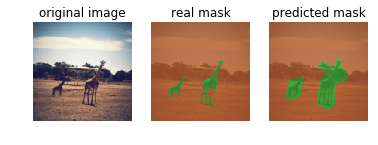

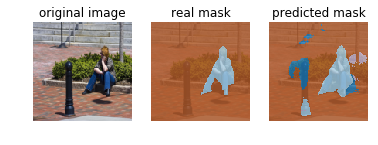

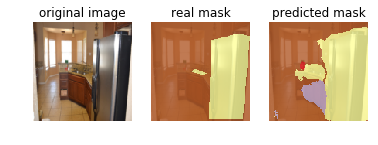

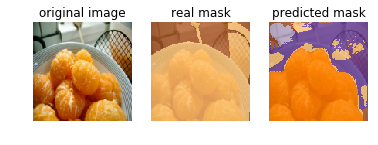

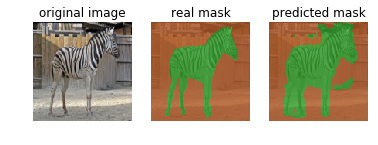

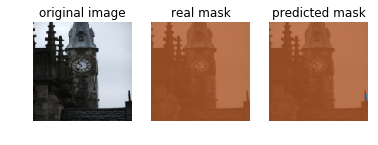

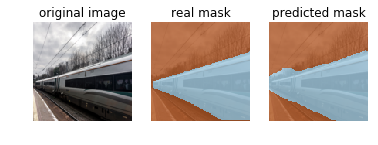

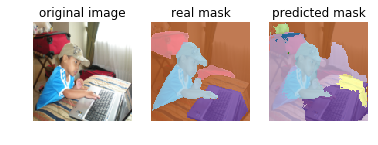

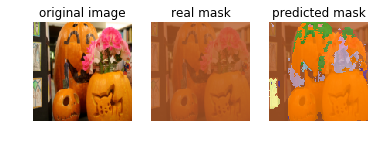

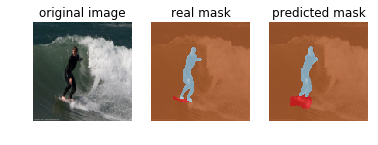

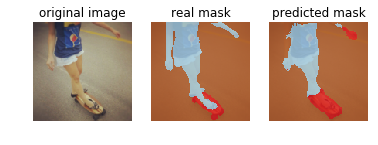

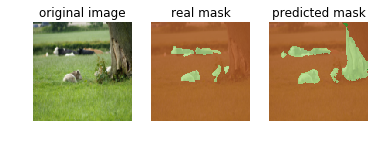

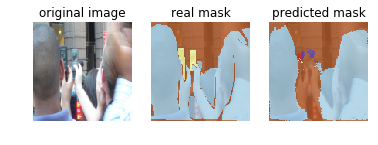

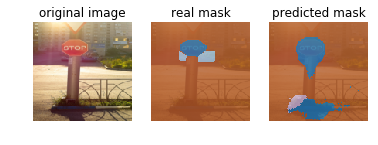

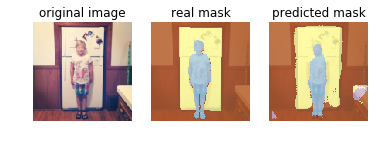

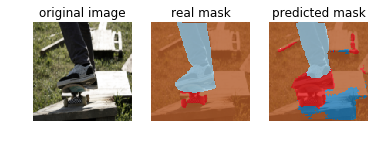

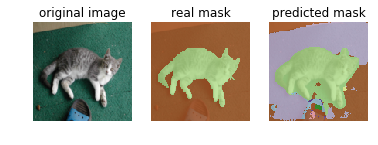

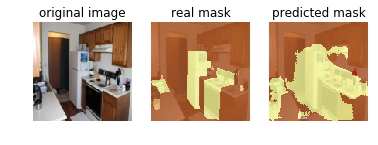

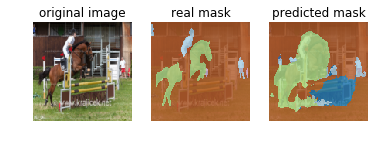

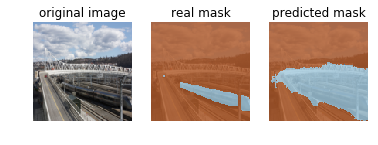

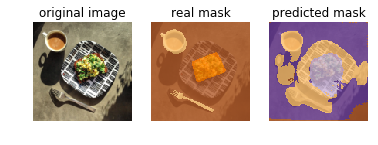

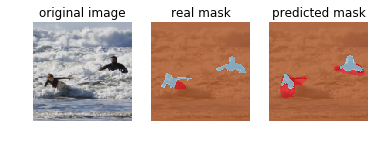

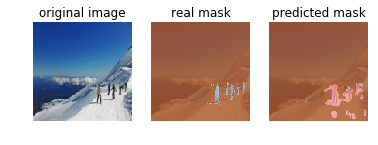

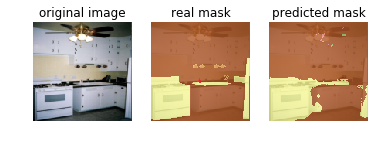

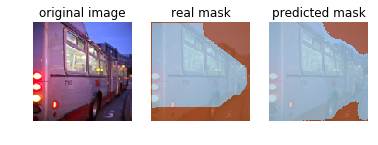

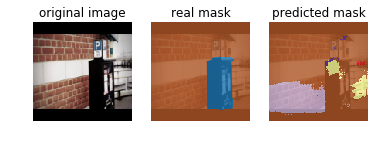

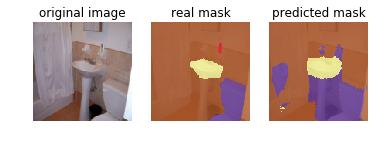

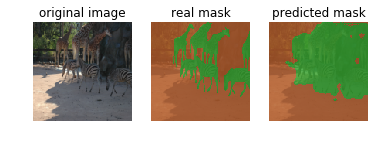

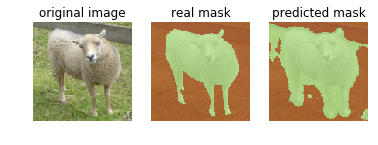

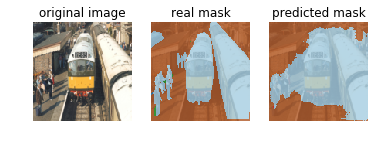

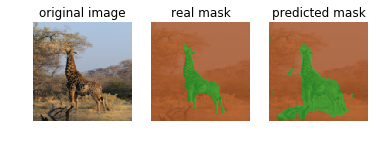

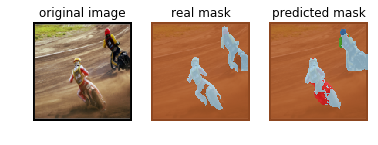

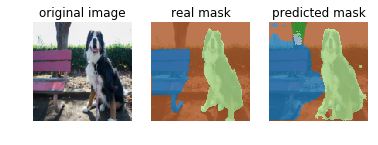

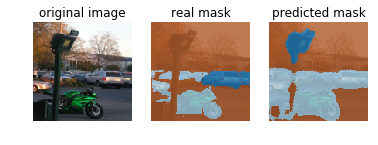

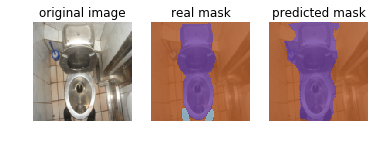

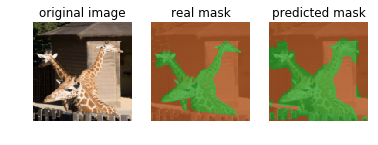

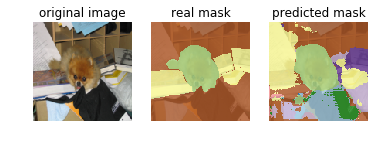

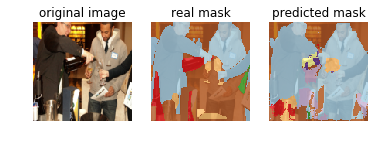

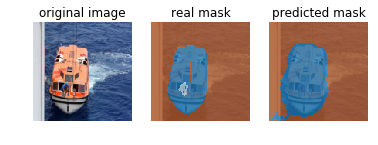

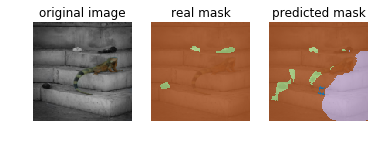

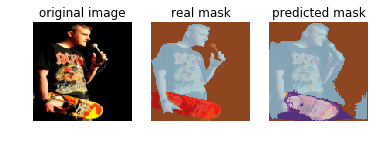

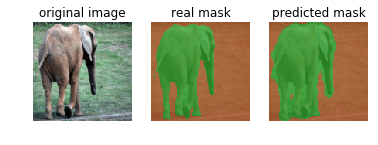

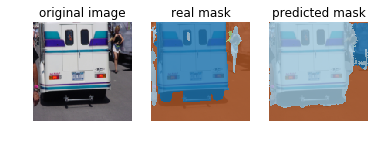

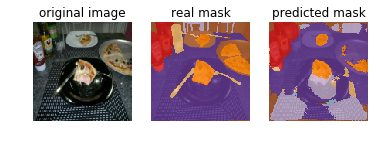

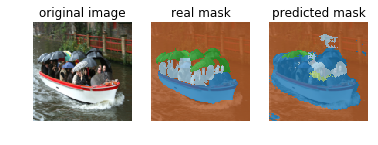

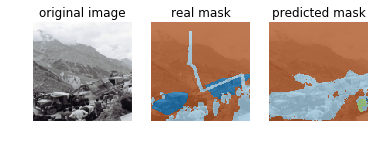

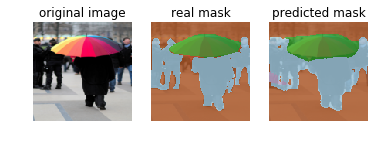

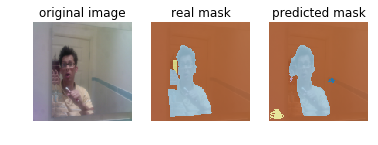

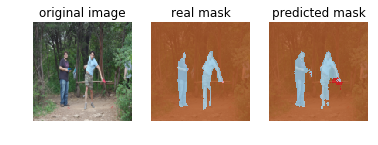

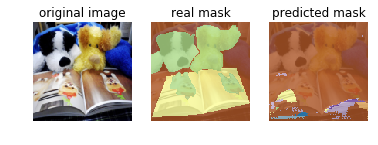

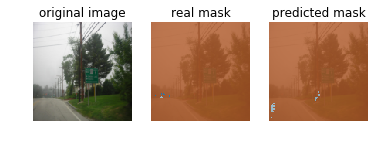

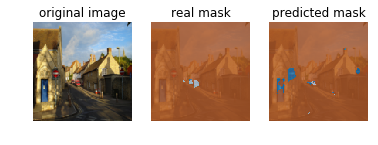

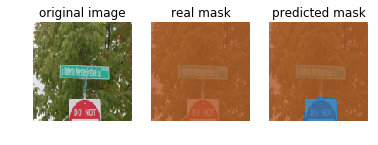

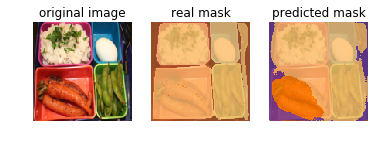

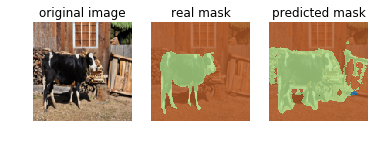

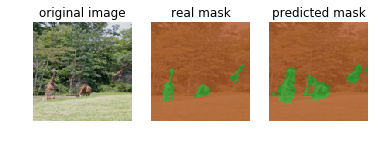

In [17]:
visualize_mask(val_loader, 20)

In [18]:
val_acc = trainer.evaluate_meanIOU(val_loader, ignore_background=True)
print("Val meanIOU without background: {}".format(val_acc))
train_acc = trainer.evaluate_meanIOU(train_loader, ignore_background=True)
print("Train meanIOU without background: {}".format(train_acc))

val_acc = trainer.evaluate_meanIOU(val_loader, ignore_background=False)
print("Val meanIOU with background: {}".format(val_acc))
train_acc = trainer.evaluate_meanIOU(train_loader, ignore_background=False)
print("Train meanIOU with background: {}".format(train_acc))

Evaluating mean IOU
Val meanIOU without background: 0.30935877561569214
Evaluating mean IOU
Train meanIOU without background: 0.3577326059341431
Evaluating mean IOU
Val meanIOU with background: 0.446402308344841
Evaluating mean IOU
Train meanIOU with background: 0.470055627822876
